In this Notebook, we aim at creating some DataDriven surrogate models for the simpliest 1D Poisson Equation: 

$$
- D \Delta u = 1
$$

with D the diffusion coefficient, considerer as scalar and constant over the whole domain. 

Our goal is to create params to solutions models, i.e a mapping from D to u.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use an implicit finite difference method. 
$$
-D \frac{u_{i-1} -2u_i + u_{i+1}}{(\Delta x)^2} = 1
$$

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import random as rd
import copy

In [2]:
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'size' : 12})
rc('figure', **{'figsize' : (5, 3)})

In [3]:
sys.path.insert(1, '../..')

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_1.py file 

In [4]:
from solvers.Solver import Solver
from config_step_1 import PARAMS_SOLVER

Poisson equation in a \[0, 1\] domain and 101 points for discretizations

In [5]:
PARAMS_SOLVER

{'equation': 'Poisson', 'domain': [0.0, 1.0], 'D': 1.0, 'nx': 101}

In [6]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = Solver(params={'solver': params_solver})

In [7]:
u = solver.solve()

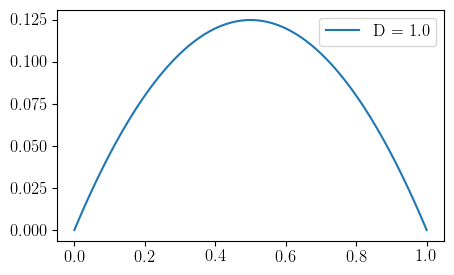

In [8]:
plt.plot(solver.x, u, label=f'D = {solver.D}')
plt.legend()
plt.show()

Now let us generate a dataset using this solver

In [9]:
Dmin, Dmax = 0.1, 10
D_list = np.linspace(Dmin, Dmax, 1000)

In [10]:
U_sols = []
for d in D_list:
    solver.change_D(d)
    U_sols.append(solver.solve())

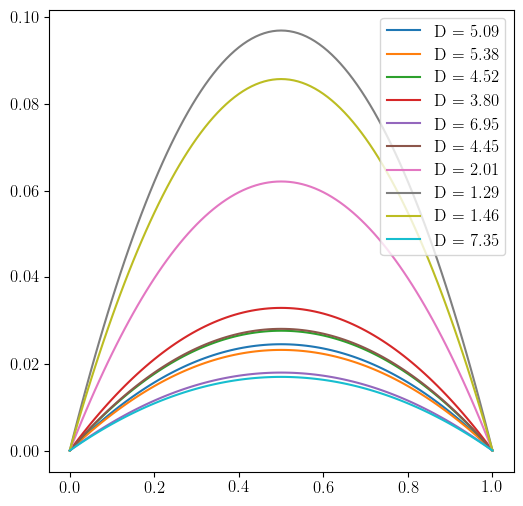

In [11]:
fig, axs = plt.subplots(1, figsize=(6, 6))
for sample in rd.sample(range(0, len(U_sols)), 10):
    axs.plot(solver.x, U_sols[sample], label=f'D = {D_list[sample]:.2f}')
plt.legend(loc=1)
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In practice, we just need to call DDMethod that will handle everything for us

In [12]:
from methods.DataDrivenMethods import DDMethod

In [13]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'DEEPONET', 'PINN', 'MLPINN', 'FNO'] 

Best hyperparameters for fitting each method have already been computed using optuna (see https://optuna.readthedocs.io/en/stable/index.html), we just need to import them 

In [14]:
from config_step_1 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [15]:
PARAMS_METHODS['PINN']

{'method_name': 'PINN',
 'layer_dims': [2, 20, 20, 20, 1],
 'activations': ['relu', 'tanh', 'softplus'],
 'device': 'cpu',
 'seed': 123}

Create DDMethod object for each method

In [16]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

Data preparation for training 

In [17]:
# MLP/POD/FNO Data preparation
U_sols = np.stack(U_sols)
D = torch.Tensor(D_list).view(-1, 1)
U = torch.Tensor(U_sols)
D_train, D_val, U_train, U_val = sklearn.model_selection.train_test_split(D, U,test_size=0.2, random_state=123)

In [18]:
# DEEPONET/PINN Data preparation
d_train, d_val, u_train, u_val = sklearn.model_selection.train_test_split(D_list, U_sols, test_size=0.2, random_state=123)

D_train_repeated = torch.Tensor([[d] * len(solver.x) for d in d_train]).view(-1, 1)
D_val_repeated = torch.Tensor([[d] * len(solver.x) for d in d_val]).view(-1, 1)
x = torch.Tensor(solver.x).view(-1, 1)
X_train = x.repeat(d_train.shape[0], 1)
X_val = x.repeat(d_val.shape[0], 1)

DX_train = torch.cat((D_train_repeated, X_train), dim=1)
DX_val = torch.cat((D_val_repeated, X_val), dim=1)
dU_train = torch.Tensor(u_train.flatten())
dU_val = torch.Tensor(u_val.flatten())

Fit all methods using fit function on DDMethod object

In [19]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=U_sols)
    elif method in ['MLP']:
        # all_methods[method].fit(hyperparameters=hyperparams_method, U_train=U_train, U_val=U_val, D_train=D_train, D_val=D_val)
        all_methods[method].load_state_dict('optuna/step_1/MLP.pt')
    elif method == 'DEEPONET':
        # all_methods[method].fit(hyperparameters=hyperparams_method, U_train=dU_train, U_val=dU_val, DX_train=DX_train, DX_val=DX_val)
        all_methods[method].load_state_dict('optuna/step_1/DEEPONET.pt')
    elif method == 'PINN':
        all_methods[method].fit(hyperparameters=hyperparams_method, DX_train=DX_train, DX_val=DX_val)
        # all_methods[method].load_state_dict('optuna/step_1/PINN.pt')
    elif method == 'MLPINN':
        # all_methods[method].fit(hyperparameters=hyperparams_method, DX_train=DX_train, DX_val=DX_val, U_train=U_train, U_val=U_val)
        all_methods[method].load_state_dict('optuna/step_1/MLPINN.pt')
    elif method == 'FNO':
        # all_methods[method].fit(hyperparameters=hyperparams_method, D_train=D_train, D_val=D_val, U_train=U_train, U_val=U_val)
        all_methods[method].load_state_dict('optuna/step_1/FNO.pt')

Fitting POD
POD fitted
Fitting PINN


[epoch: 100 : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [01:01<00:00,  1.63it/s]

PINN fitted


In [ ]:
# for method in all_methods:
#     # if method in ['MLP', 'PINN', 'DEEPONET', 'FNO', 'MLPINN']:
#     if method in ['FNO']:
#         torch.save({'model_state_dict': all_methods[method].state_dict,
#                     'loss_dict': all_methods[method].loss_dict(),
#                     }, f'optuna/step_1/{method}.pt')

# torch.save(all_methods['MLP'].state_dict(), 'optuna/step_1/MLP.pt')
# torch.save(all_methods['DEEPONET'].state_dict(), 'optuna/step_1/DONUT.pt')
# torch.save(all_methods['PINN'].state_dict(), 'optuna/step_1/PINN.pt')
# torch.save(all_methods['MLPINN'].state_dict(), 'optuna/step_1/MLPINN.pt')

# Plot performances for each method

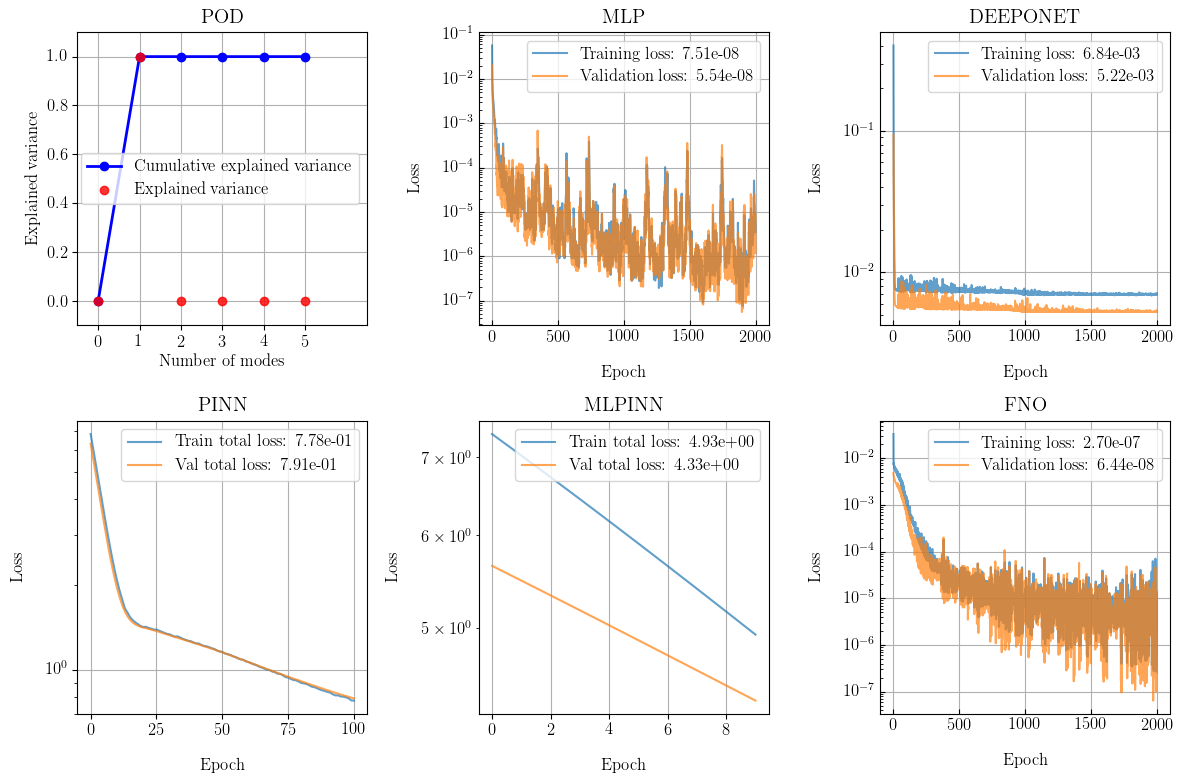

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8)) 

for i, (ax, method) in enumerate(zip(axs.flatten(), all_methods)):
    all_methods[method].plot(ax)
    ax.title.set_text(method)
    
fig.tight_layout()
plt.show()

## In distribution analysis

/work/lechevaa/PycharmProjects/CEMRACS_SciML/notebooks/PoissonEquation/../../methods/DeepONet.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343904639/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  output = torch.matmul(weights, basis.T)


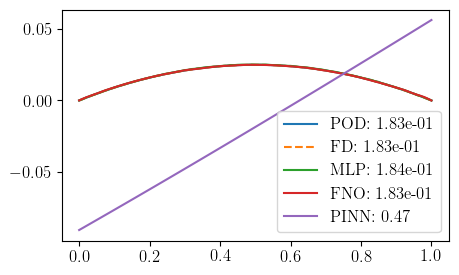

In [21]:
new_D = 5.
solver.change_D(new_D=new_D)
U_FD = solver.solve()
U_MLP = all_methods['MLP'].apply_method(new_D).detach().numpy()
U_POD = all_methods['POD'].apply_method(new_D)
U_DONUT = all_methods['DEEPONET'].apply_method(new_D)
U_PINN = all_methods['PINN'].apply_method(new_D)
U_MLPINN = all_methods['MLPINN'].apply_method(new_D)
U_FNO = all_methods['FNO'].apply_method([new_D]).flatten().detach().numpy()

plt.plot(solver.x, U_POD, label=f'POD: {np.linalg.norm(U_POD, 2):.2e}')
plt.plot(solver.x, U_FD, '--', label=f'FD: {np.linalg.norm(U_FD, 2):.2e}')
plt.plot(solver.x, U_MLP, label=f'MLP: {np.linalg.norm(U_MLP, 2):.2e}')
plt.plot(solver.x, U_FNO, label=f'FNO: {np.linalg.norm(U_FNO, 2):.2e}')
# plt.plot(solver.x, U_DONUT, label=f'DEEPONET: {np.linalg.norm(U_DONUT, 2):.2e}')
plt.plot(solver.x, U_PINN, label=f'PINN: {np.linalg.norm(U_PINN, 2):.2f}')
# plt.plot(solver.x, U_MLPINN, label=f'MLPINN: {np.linalg.norm(U_MLPINN, 2):.2f}')
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

all_methods['POD'].parity_plot(U=U_val, D=D_val, ax=axs[0][0], label='POD')
all_methods['MLP'].parity_plot(U=U_val, D=D_val, ax=axs[0][1], label='MLP')
all_methods['DEEPONET'].parity_plot(U=dU_val, D=DX_val, ax=axs[0][2], label='DEEPONET')
all_methods['PINN'].parity_plot(U=U_val, D=DX_val, ax=axs[1][0], label='PINN')
all_methods['MLPINN'].parity_plot(U=U_val, D=DX_val, ax=axs[1][1], label='MLPINN')
all_methods['FNO'].parity_plot(U=U_val, D=D_val, ax=axs[1][2], label='FNO')

for ax in axs.flatten():
    ax.legend()
fig.tight_layout()
plt.show()

## Out of Distribution

In [ ]:
new_D = 11.
solver.change_D(new_D=new_D)
U_FD = solver.solve()
U_MLP = all_methods['MLP'].apply_method(new_D).detach().numpy()
U_POD = all_methods['POD'].apply_method(new_D)
U_DONUT = all_methods['DEEPONET'].apply_method(new_D)
U_PINN = all_methods['PINN'].apply_method(new_D)
U_MLPINN = all_methods['MLPINN'].apply_method(new_D)
U_FNO = all_methods['FNO'].apply_method([new_D]).flatten().detach().numpy()


plt.plot(solver.x, U_FD, '--', label=f'FD: {np.linalg.norm(U_FD, 2):.2e}')
plt.plot(solver.x, U_POD, label=f'POD: {np.linalg.norm(U_POD, 2):.2e}')
plt.plot(solver.x, U_MLP, label=f'MLP: {np.linalg.norm(U_MLP, 2):.2e}')
# plt.plot(solver.x, U_DONUT, label=f'DEEPONET: {np.linalg.norm(U_DONUT, 2):.2e}')
# plt.plot(solver.x, U_PINN, label=f'PINN: {np.linalg.norm(U_PINN, 2):.2e}')
# plt.plot(solver.x, U_MLPINN, label=f'MLPINN: {np.linalg.norm(U_MLPINN, 2):.2e}')
plt.plot(solver.x, U_FNO, label=f'FNO: {np.linalg.norm(U_FNO, 2):.2e}')
plt.legend()
plt.show()

## Parity plot

In [ ]:
#### OUT OF DISTRIBUTION D GENERATION ######
OOD_D = np.linspace(0.01, 0.1, 101)
U_OOD_FD = []
for d in OOD_D:
    solver.change_D(new_D=d)
    U_OOD_FD.append(solver.solve())

###### MLP + POD DATA PREPARATION ########
U_OOD_FD = np.stack(U_OOD_FD)
OOD_D = torch.Tensor(OOD_D).view(-1, 1)
U_OOD_FD = torch.Tensor(U_OOD_FD)

#### DEEPONET DATA PREPARATION ########
OOD_D_repeated = torch.Tensor([[d] * len(solver.x) for d in OOD_D]).view(-1, 1)
OOD_X = torch.Tensor(solver.x).view(-1, 1)
OOD_X = OOD_X.repeat(OOD_D.shape[0], 1)
OOD_DX = torch.cat([OOD_D_repeated, OOD_X], axis=1)

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

all_methods['POD'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=axs[0][0], label='POD')
all_methods['MLP'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=axs[0][1], label='MLP')
all_methods['DEEPONET'].parity_plot(U=U_OOD_FD.flatten(), D=OOD_DX, ax=axs[0][2], label='DEEPONET')
all_methods['PINN'].parity_plot(U=U_OOD_FD, D=OOD_DX, ax=axs[1][0], label='PINN')
all_methods['MLPINN'].parity_plot(U=U_OOD_FD, D=OOD_DX, ax=axs[1][1], label='MLPINN')
all_methods['FNO'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=axs[1][2], label='FNO')
for ax in axs.flatten():
    ax.legend()
plt.tight_layout()
plt.show()